In [1]:
import pandas as pd
import os
import zipfile
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
shutil.move('C:/Users/ayush/Downloads/kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))
!kaggle datasets download -d lantian773030/pokemonclassification

Dataset URL: https://www.kaggle.com/datasets/lantian773030/pokemonclassification
License(s): copyright-authors




  0%|          | 0.00/417M [00:00<?, ?B/s]
  0%|          | 1.00M/417M [00:00<03:09, 2.31MB/s]
  1%|          | 3.00M/417M [00:00<01:06, 6.58MB/s]
  1%|▏         | 6.00M/417M [00:00<00:34, 12.4MB/s]
  2%|▏         | 8.00M/417M [00:00<00:29, 14.5MB/s]
  3%|▎         | 11.0M/417M [00:00<00:22, 19.0MB/s]
  3%|▎         | 14.0M/417M [00:00<00:18, 22.3MB/s]
  4%|▍         | 17.0M/417M [00:01<00:17, 24.1MB/s]
  5%|▍         | 20.0M/417M [00:01<00:20, 20.0MB/s]
  6%|▌         | 23.0M/417M [00:01<00:33, 12.4MB/s]
  6%|▋         | 27.0M/417M [00:03<01:34, 4.32MB/s]
  7%|▋         | 29.0M/417M [00:03<01:23, 4.86MB/s]
  8%|▊         | 32.0M/417M [00:04<01:16, 5.30MB/s]
  8%|▊         | 34.0M/417M [00:05<01:55, 3.48MB/s]
  9%|▊         | 36.0M/417M [00:06<01:55, 3.47MB/s]
  9%|▉         | 38.0M/417M [00:07<02:21, 2.81MB/s]
 10%|▉         | 41.0M/417M [00:07<01:34, 4.16MB/s]
 10%|█         | 43.0M/417M [00:07<01:15, 5.18MB/s]
 11%|█         | 45.0M/417M [00:07<01:01, 6.35MB/s]
 11%|█▏        | 47.

In [4]:
# Extracting all files to the current directory
zip_file_path = 'pokemonclassification.zip'
extraction_dir = os.getcwd()
os.makedirs(extraction_dir, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [5]:
class_list = pd.read_csv('class_sheet.csv')

In [6]:
# Removing all classes with bad data
class_list = class_list[class_list['Bad_Data'] != 1]

In [7]:
# Getting Pokemons that are winged and not winged
winged = class_list[class_list['Winged'] == 1]
winged = winged['Pokemon']
not_winged = class_list[class_list['Not_Winged'] == 1]
not_winged = not_winged['Pokemon']

In [8]:
# Getting all pokemons
all_classes = os.listdir('PokemonData')

In [9]:
# Making a data frame that has the image paths and their classifcation
image_paths = []
valid_extensios = ['.jpg', '.jpeg', '.png']
for folder in winged:
    image_names = os.listdir('PokemonData/' + folder)
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        if file_extension not in valid_extensios:
            continue
        image_path = 'PokemonData/' + folder + '/' + image
        image_paths.append({'File_Path': image_path, 'Source': 'Winged'})
for folder in not_winged:
    image_names = os.listdir('PokemonData/' + folder)
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        if file_extension not in valid_extensios:
            continue
        image_path = 'PokemonData/' + folder + '/' + image
        image_paths.append({'File_Path': image_path, 'Source': 'Not Winged'})
df = pd.DataFrame(image_paths)

In [10]:
# Sanity check to make sure all file paths exist
for index, row in df.iterrows():
    if not os.path.exists(row['File_Path']):
        print(row)

In [11]:
# Sanity check to make sure there are only 2 classes
for index, row in df.iterrows():
    if row['Source'] not in ['Winged', 'Not Winged']:
        print(row)

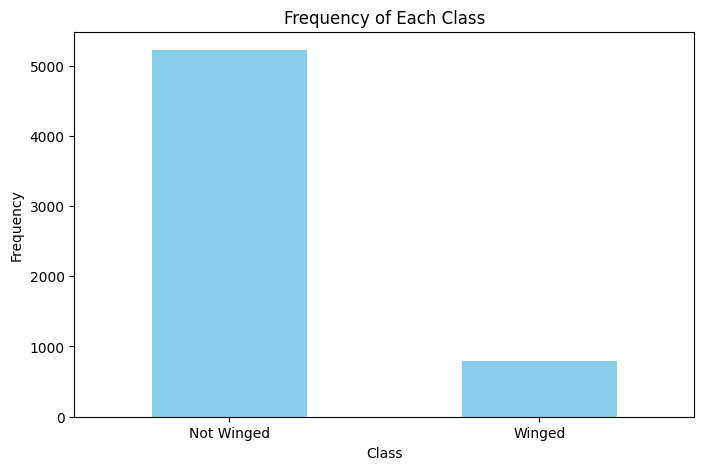

In [12]:
# Plotting frequencies of classes to check for data imbalance
source_counts = df['Source'].value_counts()
plt.figure(figsize=(8, 5))
source_counts.plot(kind='bar', color='skyblue')
plt.title("Frequency of Each Class")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)  
plt.show()

### Observation: Not Winged class has way more examples than Winged, We'd either have to sample equal number of images from both sets or use a weight balanced optimizer

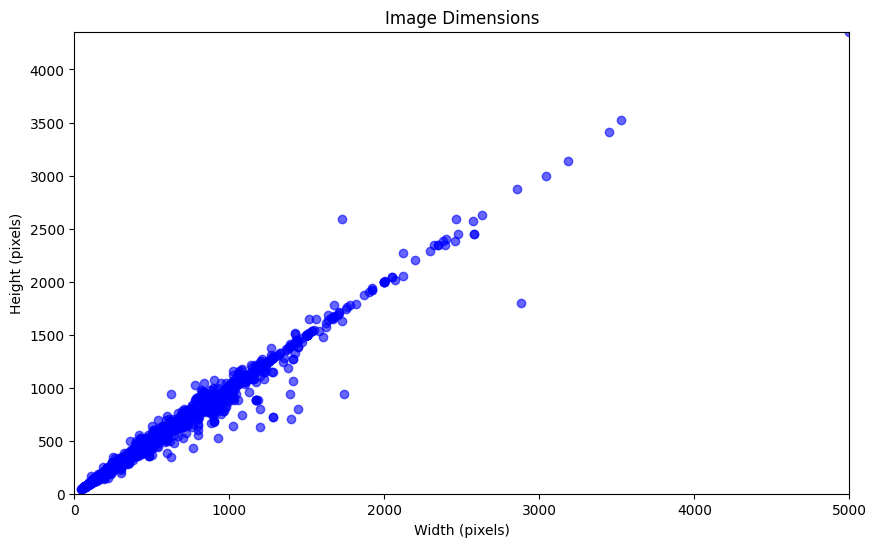

In [13]:
# Plotting the image pixel values
widths = []
heights = []

for file_path in df['File_Path']:
    if os.path.exists(file_path):  
        with Image.open(file_path) as img:
            widths.append(img.width)
            heights.append(img.height)

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', alpha=0.6)
plt.title("Image Dimensions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.xlim(0, max(widths))  
plt.ylim(0, max(heights))  
plt.show()

### Observation: The dimensions of images are varying, we'd have to resize all of them to a common size

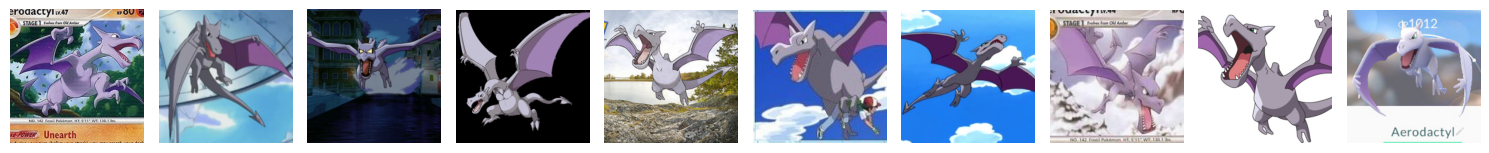

In [14]:
# Plotting 10 images after they've been resized
new_size = (224, 224)
resized_images = []

for image_path in df['File_Path'][:10]:  
    with Image.open(image_path) as img: 
        resized_img = img.resize(new_size)
        resized_images.append(resized_img)

plt.figure(figsize=(15, 10))
for i, resized_img in enumerate(resized_images):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(resized_img)
    plt.axis('off')  
plt.tight_layout()
plt.show()

### Observation: After resizing, the image retains its prominent features, so we can expect a good fit

# Data Preprocessing

In [15]:
# Arrays to store flattened images and their classifications
X = []
y = []

In [16]:
# Going through all images and resizing them, converting them to grayscale and normalizing pixel values
for index, row in df.iterrows():
    image_path = row['File_Path']
    img = Image.open(image_path)

    # Resize images to 224 x 224
    img = img.resize((224, 224))  

    # Convert images to grayscale
    img = img.convert('L') 
    
    # Normalize pixel values
    img = np.array(img) / 255.0  
    
    X.append(img)
    y.append(1 if row['Source'] == 'winged' else 0)
X = np.array(X)
y = np.array(y)

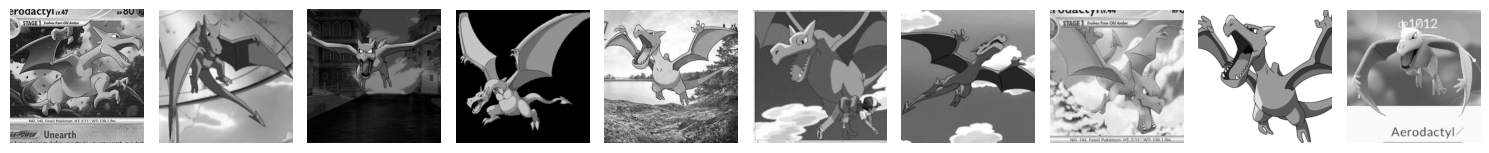

In [17]:
# Plotting the first 10 images after preprocessing
plt.figure(figsize=(15, 10))
for i, img in enumerate(X[:10]):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img, cmap='gray') 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [18]:
# Creating Train/Validate/Test splits (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)